**Importing the libraries needed** 

In [1]:
import numpy as np
import pandas as pd
import time


import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import gensim
from gensim.models import KeyedVectors

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import SpatialDropout1D, Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

import itertools
from numpy import loadtxt
from keras.models import load_model

import warnings
warnings.filterwarnings("ignore")

**Connecting to google drive**

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


 
**Uploading the dataset**

In [3]:
# path_data = "/content/gdrive/MyDrive/thesis/LABR.tsv"

# LABR = pd.read_csv(path_data, sep='\t')

path_data = "/content/gdrive/MyDrive/thesis/LABR.xlsx"

LABR = pd.read_excel(path_data)

In [4]:
data = LABR

**printing the first 3 rows of the data**

In [5]:
data.head(3)

,rating,Unnamed: 1,Unnamed: 2,Unnamed: 3,review
0,4.0,338670838.0,7878381.0,13431841.0,عزازيل الذي صنعناه ،الكامن في أنفسنا يذكرني يو...
1,4.0,39428407.0,1775679.0,3554772.0,من أمتع ما قرأت من روايات بلا شك. وحول الشك تد...
2,4.0,32159373.0,1304410.0,3554772.0,رواية تتخذ من التاريخ ،جوًا لها اختار المؤلف ف...


**printing the shape of the dataset nbr of row and columns**

In [6]:
print("Data contient {} lignes et {} colonnes.".format(data.shape[0], data.shape[1]))

Data contient 63066 lignes et 5 colonnes.


 **printing the fiels with missed values**



In [7]:
data.isnull().sum()

rating        0
Unnamed: 1    0
Unnamed: 2    0
Unnamed: 3    0
review        0
dtype: int64

**printing the number of the duplicated rows**

In [8]:
print("On a  {} doublons dans Data.".format(data.duplicated().sum()))

On a  2464 doublons dans Data.


In [9]:
data.drop_duplicates(inplace = True)

In [10]:
print("On a  {} doublons dans Data.".format(data.duplicated().sum()))

On a  0 doublons dans Data.


**checking the types of the fiels in the data**

In [11]:
data.dtypes

rating        float64
Unnamed: 1    float64
Unnamed: 2    float64
Unnamed: 3    float64
review         object
dtype: object

**function for printing the pie**

In [12]:
def pie(data,col):
    labels = data[col].value_counts().keys().tolist()
    n = len(labels)
    if n==2:
        colors = ['#66b3ff', '#fb3999']
    elif n==3:
        colors = ['#66b3ff', '#fb3999', '#ffcc99']
    elif n==4:
        colors = ['#66b3ff', '#fb3999', '#ffcc99',"#66f3ff"]
    elif n==5:
        colors = ['#66b3ff', '#fb3999', '#ffcc99',"#66f3ff",'#adcc99']
    elif n==6:
        colors = ['#66b3ff', '#fb3999', '#ffcc99',"#66f3ff",'#adcc99',"#db7f23"]
    
    fig1, f1 = plt.subplots()
    f1.pie(data[col].value_counts(), labels=labels, colors = colors, autopct='%1.1f%%',shadow=False, startangle=60) 
    f1.axis('equal')
    plt.tight_layout()
    plt.show()
    
def histo(data,col):
    plt.figure(figsize = (10, 8))
    sns.histplot(data=data, x=col, hue = data[col], fill=True)

**Counting the % of each classe**

In [13]:
data.rating.value_counts(normalize = True)

5.0    0.375433
4.0    0.301508
3.0    0.193310
2.0    0.083479
1.0    0.046269
Name: rating, dtype: float64

**Printing the distribution of the classes**

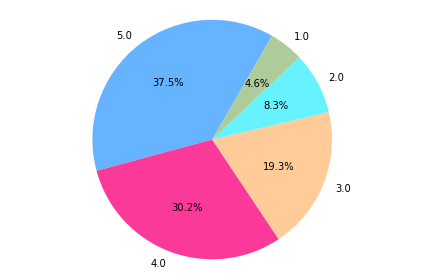

In [14]:
pie(data, "rating")

**Repartitionning the data to 2 classes**

In [15]:
positive_reviews = data[data["rating"] > 3]
positive_reviews["sentiment"] = 1

negative_reviews = data[data["rating"] < 3]
negative_reviews["sentiment"] = 0

data = pd.concat([positive_reviews, negative_reviews], ignore_index = True)

 **printing the number of rows in both classes**

In [16]:
print("data contient {} lignes.".format(data.shape[0]))

print("Positive_reviews contient {} lignes.".format(positive_reviews.shape[0]))

print("Negative_reviews contient {} lignes.".format(negative_reviews.shape[0]))

data contient 48887 lignes.
Positive_reviews contient 41024 lignes.
Negative_reviews contient 7863 lignes.


**printing the new distribution of the data**

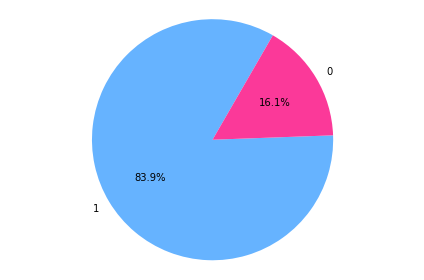

In [17]:
pie(data,"sentiment")

**printing the new distribution in histogramme**

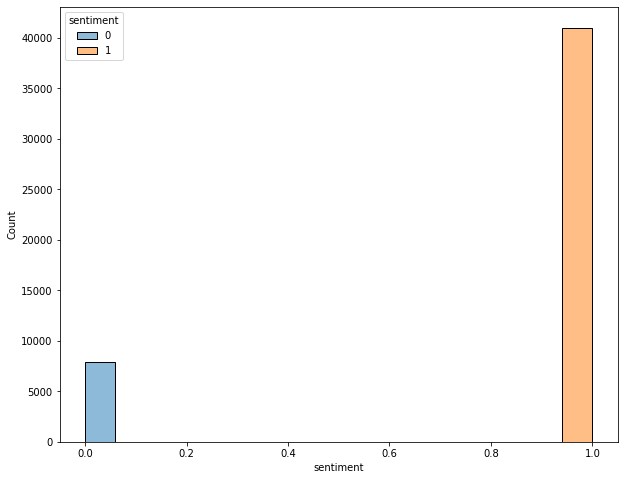

In [18]:
histo(data,"sentiment")

**function to count the length of reviews**



In [19]:
def compte_mots(phrase):
    return len(str(phrase).split())

data["len_review"] = data["review"].apply(compte_mots)
positive_reviews['len_review'] = positive_reviews["review"].apply(compte_mots)
negative_reviews['len_review'] = negative_reviews["review"].apply(compte_mots)

**printing the max  length of the positive and negative reviews**

In [20]:
print("Le maximum de mots utilisé dans les reviews positives est :", max(positive_reviews.len_review))
print("Le moyen de mots utilisé dans les reviews positives est :", np.mean(positive_reviews.len_review))
print("-------------------------------------------------------------------------------------------------------")
print("Le maximum de mots utilisé dans les reviews négatives est :", max(negative_reviews.len_review))
print("Le moyen de mots utilisé dans les reviews négatives est :", np.mean(negative_reviews.len_review))

Le maximum de mots utilisé dans les reviews positives est : 3419
Le moyen de mots utilisé dans les reviews positives est : 63.5811232449298
-------------------------------------------------------------------------------------------------------
Le maximum de mots utilisé dans les reviews négatives est : 1535
Le moyen de mots utilisé dans les reviews négatives est : 61.01144601297215


(0.0, 400.0)

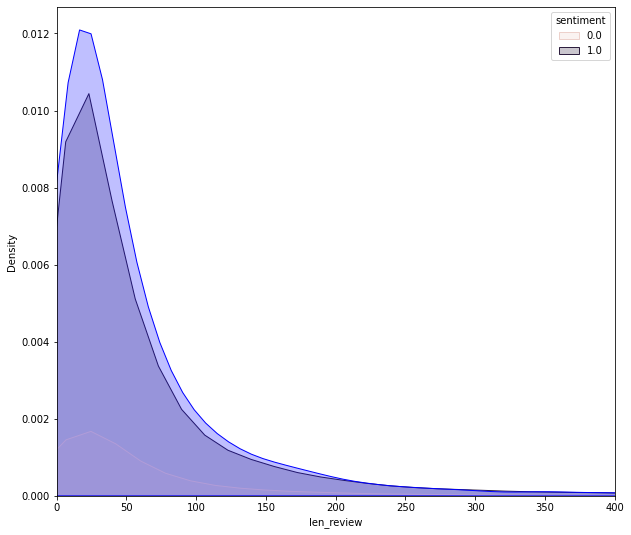

In [21]:
plt.figure(figsize=(10,9))

p1=sns.kdeplot(positive_reviews['len_review'], hue = data['sentiment'],  shade=True, color="r")
p1=sns.kdeplot(negative_reviews['len_review'], shade=True, color="b")

plt.xlim(0, 400)

**Deleting unused fields**

In [22]:
data.drop(['rating', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3'], axis = 1, inplace = True)
data.head(3)

,review,sentiment,len_review
0,عزازيل الذي صنعناه ،الكامن في أنفسنا يذكرني يو...,1,106
1,من أمتع ما قرأت من روايات بلا شك. وحول الشك تد...,1,17
2,رواية تتخذ من التاريخ ،جوًا لها اختار المؤلف ف...,1,32


In [23]:
df = data

**the function of the preprocessing**

In [24]:
def preprocessing(x):
    x = re.sub('@[^\s]+', ' ', x)
    x = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',x)
    
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030""]+", flags=re.UNICODE)
    emoji_pattern.sub(r'', x)
    
    ar_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ#'''
    en_punctuations = string.punctuation
    punctuations = ar_punctuations + en_punctuations
    x = x.translate(str.maketrans('', '', punctuations))
 
    arabic_diacritics = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    x = re.sub(arabic_diacritics, '', str(x)) 
    
#     x = re.sub("[إأآا]", "ا", x)
#     x = re.sub("ى", "ي", x)
#     x = re.sub("ة", "ه", x)
#     x = re.sub("گ", "ك", x)
#     x = re.sub(r'(.)\1+', r'\1', x)
    
    return x



**preprocessing the reviews and printing the time spent**

In [25]:
%%time
data["Clean_reviews"] = data.review.apply(lambda x: preprocessing(str(x)))

CPU times: user 2.94 s, sys: 15.9 ms, total: 2.96 s
Wall time: 2.98 s


**printing a review before and after preprocessing**

In [26]:
print('- Avant le prétraitement \n\n',data["review"][4])
print("\n-----------------------------------------------\n")
print('- Après le prétraitement \n\n',data["Clean_reviews"][4])

- Avant le prétraitement 

 عزازيل هو اسم رواية يوسف زيدان الثانية و التي صَدرت مؤخراً عن دار الشروق. جذبني الاسم في البداية لقراءتها. "عزازيل" هو أحد أسماء الشيطان في التقليد اليهودي - المسيحي، لهذا تصورت أن الرواية تتحدث عن الشيطان أو عن عالم ما وراء الطبيعة. لكن الرواية بَدت أكثر متعةً و تشويقاً و - أيضاً - عُمقاً! ينسج المؤلف خيوطه المحكمة من أول صفحة. و يقدّم صفحات الرواية كترجمة لرقائق وُجدت مكتوبة منذ القرن الرابع. و يختلق قصةً عن المترجم كي يؤصل للجو التاريخي للرواية. ثم ينتقل الحديث للراهب "هيبا" المصري الذي يكتب الرواية على لسانه (و إمعاناً في اتقان الحبكة، فإن الهوامش تحوي تعليقات للناسخ العربي و للمترجم أحياناً). هكذا يدخل القاريء في جوِ تاريخي محكم شبه - حقيقي، خاصةً مع ظهور الشخصيات الأخرى للرواية و التي هي شخصيات تاريخية حقيقيّة. فباستثاء "هيبا" و محيطه، فإن جميع شخصيات الرواية الأساسية حقيقية: "نسطور" أسقف القسطنطينية، "كيرلس" أسقف الأسكندرية، "هيباتيا" العالمة و الفيلسوفة. من روعة الرواية أن جعلت من هؤلاء الشخصيات - الذين هم صفحات تاريخية صامتة - أبطالاً من لحمٍ و دم، 

**Saving the cleaned data in a csv file**

In [27]:
data.to_csv("cleaned_labr.csv")

**asigning the reviews and classes to a new variables**




In [28]:
X = data.Clean_reviews
y = data.sentiment

**spliting the data to train and test set**



In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.20, 
                                                    random_state = 42)

**printing the number of the train set and the test set**

In [30]:
print('Train set', X_train.shape)
print('Test set', X_test.shape)

Train set (39109,)
Test set (9778,)


In [31]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Uploading the fsttext pretrained word embedding with 150 dimension**

In [32]:
%%time
target_word_vec = KeyedVectors.load_word2vec_format("/content/gdrive/MyDrive/thesis/cc.ar.150.vec", binary = False)

CPU times: user 2min 28s, sys: 3.37 s, total: 2min 32s
Wall time: 2min 42s


**tokenization of the reviews**

In [33]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

CPU times: user 3.21 s, sys: 46.9 ms, total: 3.26 s
Wall time: 3.56 s


In [34]:
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1

**making all reviews of the same length 3456**

In [35]:
%%time
MAX_SEQUENCE_LENGTH = 3456

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train),
                        maxlen = MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:", X_train.shape)
print("Testing X Shape:", X_test.shape)

Training X Shape: (39109, 3456)
Testing X Shape: (9778, 3456)
CPU times: user 3.27 s, sys: 296 ms, total: 3.56 s
Wall time: 4.08 s


**Construction of the embedding matrix**

In [36]:
%%time
embedding_matrix = np.zeros((vocab_size, 150))

for word, i in word_index.items():
    if word in target_word_vec :
        embedding_vector = target_word_vec[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

CPU times: user 598 ms, sys: 111 ms, total: 709 ms
Wall time: 708 ms


In [37]:
embedding_matrix.shape[0] == vocab_size

True

**Creating the model**

In [41]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 
                            150, 
                            weights = [embedding_matrix], 
                            input_length = MAX_SEQUENCE_LENGTH, 
                            trainable=False)
model.add(embedding_layer)
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(Bidirectional(LSTM(64, dropout=0.2, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer = Adam(learning_rate=0.001), 
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 3456, 150)         30108750  
                                                                 
 conv1d_1 (Conv1D)           (None, 3455, 64)          19264     
                                                                 
 bidirectional_1 (Bidirectio  (None, 3455, 128)        66048     
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                

**fitting the model to the dataset**

In [42]:
history = model.fit(X_train, y_train, validation_split=0.15, batch_size = 128, epochs=20, verbose=1)

Epoch 1/20
260/260 [==============================] - 105s 395ms/step - loss: 0.4087 - accuracy: 0.8430 - val_loss: 0.3180 - val_accuracy: 0.8648
Epoch 2/20
260/260 [==============================] - 97s 373ms/step - loss: 0.3127 - accuracy: 0.8717 - val_loss: 0.2880 - val_accuracy: 0.8826
Epoch 3/20
260/260 [==============================] - 98s 377ms/step - loss: 0.2904 - accuracy: 0.8823 - val_loss: 0.2832 - val_accuracy: 0.8838
Epoch 4/20
260/260 [==============================] - 97s 372ms/step - loss: 0.2829 - accuracy: 0.8860 - val_loss: 0.2723 - val_accuracy: 0.8911
Epoch 5/20
260/260 [==============================] - 97s 374ms/step - loss: 0.2734 - accuracy: 0.8921 - val_loss: 0.2660 - val_accuracy: 0.8950
Epoch 6/20
260/260 [==============================] - 97s 373ms/step - loss: 0.2652 - accuracy: 0.8955 - val_loss: 0.2623 - val_accuracy: 0.8953
Epoch 7/20
260/260 [==============================] - 97s 373ms/step - loss: 0.2574 - accuracy: 0.8984 - val_loss: 0.2624 - val_a

**Evaluating the model**

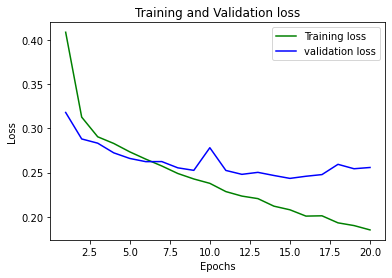

In [43]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

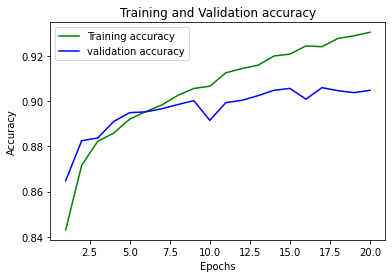

In [44]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [45]:
score = model.evaluate(X_test, y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

306/306 [==============================] - 25s 80ms/step - loss: 0.2644 - accuracy: 0.9025
accuracy: 90.25%


In [46]:
def decode_sentiment(score):
    return 1 if score>0.5 else 0

In [47]:
scores = model.predict(X_test, verbose=1)

y_pred = [decode_sentiment(x) for x in scores]

306/306 [==============================] - 24s 76ms/step


In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.55      0.65      1613
           1       0.92      0.97      0.94      8165

    accuracy                           0.90      9778
   macro avg       0.86      0.76      0.80      9778
weighted avg       0.90      0.90      0.90      9778



**function for creating confusion matrix**

In [49]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

**printing the confusion matrix**

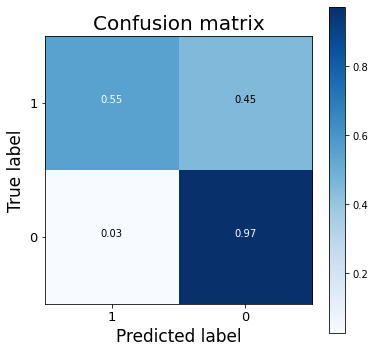

In [50]:
cnf_matrix = confusion_matrix(y_test.to_list(), y_pred)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=y_test.unique(), title="Confusion matrix")
plt.show()